In [1]:
import geopandas as gpd
from rasterio.crs import CRS
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd
from dem_stitcher.geojson_io import read_geojson_gzip
from shapely.geometry import Polygon, shape
import asf_search as asf
import concurrent.futures
from tqdm import tqdm

# Read the disturbance Data

In [2]:
df_dist_hls_val = pd.read_csv('https://raw.githubusercontent.com/OPERA-Cal-Val/DIST-Validation/main/referenceTimeSeries_last.csv')
df_dist_hls_val.head()

,ID,overallLabel,Long,Lat,changetype,20211001,20211002,20211003,20211004,20211005,...,20220921,20220922,20220923,20220924,20220925,20220926,20220927,20220928,20220929,20220930
0,1,VLmaj,-52.379792,-23.297147,Natural browning,noObs,noObs,noObs,noObs,noObs,...,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs,noObs
1,2,noChange,129.850328,-29.577240,No Change,noObs,noObs,noObs,noChange,noChange,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs
2,3,VLmin,-98.600559,33.771004,Natural browning,noObs,noObs,noChange,noChange,noChange,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs
3,4,VLmaj,19.332894,4.574903,Fire,noObs,noObs,noChange,noChange,noChange,...,noChange,noChange,noChange,noChange,noChange,noChange,noChange,noObs,noObs,noObs
4,5,VLmaj,115.619006,63.108089,Fire,noObs,noObs,noObs,noObs,noObs,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs


# Extracting "change" and Last observed "no change" indices

In [3]:
def get_index(data: list[str], val: str) -> int:
    try:
        ind = data.index(val)
    except ValueError:
        ind = len(data)
    return ind


def get_first_change(labeled_ts):
    get_index_p = lambda val: get_index(labeled_ts, val)
    indices = list(map(get_index_p, ['VLmin', 'VLmaj', 'OCmin', 'OCmaj']))
    ind = min(indices)
    ind = ind if ind < len(labeled_ts) else -1
    return ind

def get_last_noChange(labeled_ts, change_ind):
    if change_ind == -1:
        return -1
    labeled_ts_r = (labeled_ts[:change_ind][::-1])
    ind_nc_r = get_index(labeled_ts_r, 'noChange')
    ind_nc = change_ind - ind_nc_r - 1
    return ind_nc

Debugging/testing

In [4]:
IND_T = 2
row_data = list(df_dist_hls_val.iloc[IND_T])
ts_labeled = row_data[5:]
ind_c = get_first_change(ts_labeled)
ts_labeled[max(ind_c-10, 0): ind_c+10], ind_c

(['noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin'],
 119)

In [5]:
ind_nc = get_last_noChange(ts_labeled, ind_c)
ts_labeled[max(ind_nc, 0) : ind_c+ 1], ind_c

(['noChange',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'VLmin'],
 119)

## Extract dates from Table

In [6]:
def get_first_change_from_row(row):
    change_label = row['overallLabel']
    if change_label in ['VLmin', 'VLmaj', 'OCmaj', 'OCmin']:
        dates_str = row.keys().tolist()[5:]
        dates = pd.to_datetime(dates_str)
        
        labeled_ts = list(row)[5:]
        ind_c = get_first_change(labeled_ts)
        change_date = dates[ind_c]
    else:
        change_date = pd.NaT
    return change_date

def get_last_obs_date_before_change(row):
    change_label = row['overallLabel']
    if change_label in ['VLmin', 'VLmaj', 'OCmaj', 'OCmin']:
        dates_str = row.keys().tolist()[5:]
        dates = pd.to_datetime(dates_str)
        
        labeled_ts = list(row)[5:]
        ind_c = get_first_change(labeled_ts)
        ind_nc = get_last_noChange(labeled_ts, ind_c)
        last_obs_date = dates[ind_nc] if ind_nc > -1 else pd.NaT
    else:
        last_obs_date = pd.NaT

    return last_obs_date


In [7]:
df_dist_hls_val.head()

,ID,overallLabel,Long,Lat,changetype,20211001,20211002,20211003,20211004,20211005,...,20220921,20220922,20220923,20220924,20220925,20220926,20220927,20220928,20220929,20220930
0,1,VLmaj,-52.379792,-23.297147,Natural browning,noObs,noObs,noObs,noObs,noObs,...,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs,noObs
1,2,noChange,129.850328,-29.577240,No Change,noObs,noObs,noObs,noChange,noChange,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs
2,3,VLmin,-98.600559,33.771004,Natural browning,noObs,noObs,noChange,noChange,noChange,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs
3,4,VLmaj,19.332894,4.574903,Fire,noObs,noObs,noChange,noChange,noChange,...,noChange,noChange,noChange,noChange,noChange,noChange,noChange,noObs,noObs,noObs
4,5,VLmaj,115.619006,63.108089,Fire,noObs,noObs,noObs,noObs,noObs,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs


In [8]:
change_times = df_dist_hls_val.apply(get_first_change_from_row, axis=1)
last_obs_times = df_dist_hls_val.apply(get_last_obs_date_before_change, axis=1)
change_labels = df_dist_hls_val.overallLabel[:10]
print(list(zip(change_times,last_obs_times, change_times > last_obs_times ,change_labels)))

[(Timestamp('2021-10-08 00:00:00'), NaT, False, 'VLmaj'), (NaT, NaT, False, 'noChange'), (Timestamp('2022-01-28 00:00:00'), Timestamp('2022-01-06 00:00:00'), True, 'VLmin'), (Timestamp('2021-11-07 00:00:00'), Timestamp('2021-11-02 00:00:00'), True, 'VLmaj'), (Timestamp('2022-05-18 00:00:00'), Timestamp('2022-05-11 00:00:00'), True, 'VLmaj'), (Timestamp('2021-10-03 00:00:00'), NaT, False, 'VLmaj'), (NaT, NaT, False, 'noChange'), (Timestamp('2021-11-12 00:00:00'), Timestamp('2021-11-03 00:00:00'), True, 'OCmin'), (NaT, NaT, False, 'noChange'), (NaT, NaT, False, 'noChange')]


<Axes: >

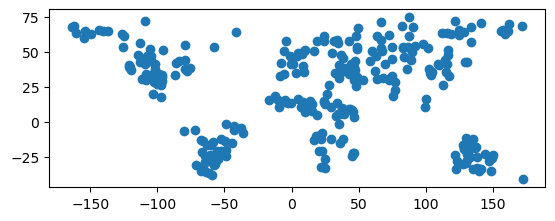

In [9]:
df_sites = gpd.GeoDataFrame({'site_id': df_dist_hls_val.ID,
                             'change_label': df_dist_hls_val.overallLabel,
                             'change_time': change_times,
                             'last_observation_time': last_obs_times},
                             geometry=gpd.points_from_xy(df_dist_hls_val.Long,
                                                         df_dist_hls_val.Lat),
                            crs=CRS.from_epsg(4326))
df_sites.plot()

In [10]:
df_sites.to_file('dist_hls_val_sites.geojson', driver='GeoJSON')

# Burst Ids

In [11]:
df_burst = read_geojson_gzip('../1_visualize_rtc_time_series/opera_burst_ids.geojson.zip')
df_burst.head()

,geometry,burst_id_jpl,is_land,is_north_america,orbit_pass
0,"POLYGON ((2.53190 4.75701, 3.29631 4.91201, 3....",t001_000025_iw1,1,False,ASCENDING
1,"POLYGON ((3.25912 4.97460, 4.06055 5.13657, 4....",t001_000025_iw2,1,False,ASCENDING
2,"POLYGON ((4.02659 5.18854, 4.73485 5.32978, 4....",t001_000025_iw3,1,False,ASCENDING
3,"POLYGON ((2.49611 4.92361, 3.26087 5.07851, 3....",t001_000026_iw1,1,False,ASCENDING
4,"POLYGON ((3.22392 5.14115, 4.02565 5.30297, 3....",t001_000026_iw2,1,False,ASCENDING


# Join Burst table and the site ids

Via a spatial join

In [12]:
df_val_bursts = gpd.sjoin(df_burst, df_sites, how='inner', predicate='intersects').reset_index(drop=True)
df_val_bursts = df_val_bursts.drop(columns=['index_right'])
df_val_bursts['track_number'] = df_val_bursts.burst_id_jpl.map(lambda burst_id_jpl: int(burst_id_jpl.split('_')[0][1:]))
df_val_bursts = df_val_bursts.sort_values(by=['site_id', 'burst_id_jpl'])
df_val_bursts.head()

,geometry,burst_id_jpl,is_land,is_north_america,orbit_pass,site_id,change_label,change_time,last_observation_time,track_number
660,"POLYGON ((-52.73133 -23.43816, -51.90414 -23.2...",t090_193169_iw1,1,False,ASCENDING,1,VLmaj,2021-10-08,NaT,90
661,"POLYGON ((-52.73133 -23.43816, -51.90414 -23.2...",t090_193169_iw1,1,False,ASCENDING,1,VLmaj,2021-10-08,NaT,90
703,"POLYGON ((-51.66339 -23.30842, -52.52125 -23.1...",t097_207419_iw2,1,False,DESCENDING,1,VLmaj,2021-10-08,NaT,97
1173,"POLYGON ((-53.01716 -23.54912, -52.25936 -23.3...",t163_349964_iw3,1,False,ASCENDING,1,VLmaj,2021-10-08,NaT,163
257,"POLYGON ((129.82540 -29.63759, 130.62076 -29.4...",t039_083584_iw3,1,False,ASCENDING,2,noChange,NaT,NaT,39


<Axes: >

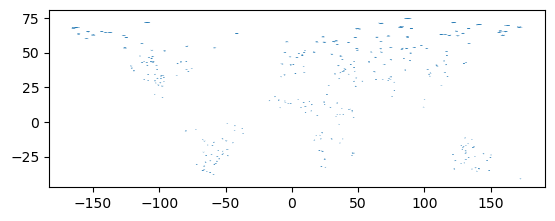

In [13]:
df_val_bursts.plot()

# Multiple bursts overlapping sites at high latitudes

In [14]:
df_burst_count = df_val_bursts[['site_id', 'orbit_pass']].groupby('site_id').count().sort_values(by='orbit_pass', ascending=False).reset_index(drop=False)
df_burst_count.head(10)

,site_id,orbit_pass
0,80,13
1,45,11
2,49,11
3,157,10
4,36,10
5,85,10
6,44,9
7,227,9
8,212,9
9,137,9


In [15]:
df_val_bursts.to_file('dist_val_bursts.geojson', driver='GeoJSON')

In [16]:
df_val_bursts[df_val_bursts.site_id == 80].head()

,geometry,burst_id_jpl,is_land,is_north_america,orbit_pass,site_id,change_label,change_time,last_observation_time,track_number
32,"POLYGON ((83.60447 68.63409, 81.42223 68.81404...",t005_009255_iw2,1,False,DESCENDING,80,noChange,NaT,NaT,5
33,"POLYGON ((83.49732 68.47183, 81.33050 68.65096...",t005_009256_iw2,1,False,DESCENDING,80,noChange,NaT,NaT,5
264,"POLYGON ((80.60798 68.26841, 82.51706 68.39427...",t041_086323_iw3,1,False,ASCENDING,80,noChange,NaT,NaT,41
265,"POLYGON ((80.51816 68.43153, 82.44089 68.55790...",t041_086324_iw3,1,False,ASCENDING,80,noChange,NaT,NaT,41
507,"POLYGON ((80.42071 68.30445, 82.46703 68.49249...",t070_148616_iw1,1,False,ASCENDING,80,noChange,NaT,NaT,70


<Axes: >

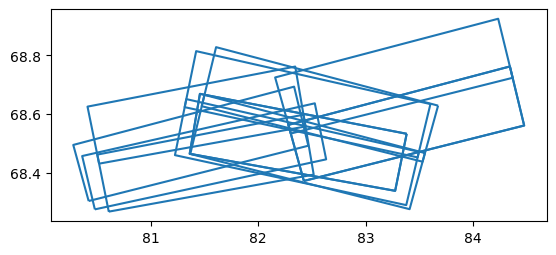

In [17]:
df_val_bursts[df_val_bursts.site_id == 80].exterior.plot()

## Get only 2 bursts from each track

In [18]:
df_val_bursts_filtered = df_val_bursts.groupby(['site_id', 'track_number']).head(2).reset_index(drop=True)
df_val_bursts_filtered.shape, df_val_bursts.shape

((1199, 10), (1261, 10))

# Getting SLC IDs

In [19]:
def get_asf_results(geo: Polygon,
                    site_id: int,
                    track_number: int,
                    burst_id: str):
    
    res = asf.geo_search(platform=[asf.PLATFORM.SENTINEL1],
                         intersectsWith=geo.wkt,
                         maxResults=100,
                         polarization=['VV+VH'], # could add just 'VV'
                         beamMode=[asf.BEAMMODE.IW],
                         relativeOrbit=[track_number],
                         processingLevel=[asf.PRODUCT_TYPE.SLC],
                         )
    
    geometry = [shape(r.geojson()['geometry']) for r in res]
    data = [r.properties for r in res]

    df_res = pd.DataFrame(data)
    df_res = gpd.GeoDataFrame(df_res,
                              geometry=geometry,
                              crs=CRS.from_epsg(4326))
    df_res['site_id'] = site_id
    df_res['jpl_burst_id'] = burst_id

    return df_res

def get_asf_results_from_record(record: dict) -> gpd.GeoDataFrame:
    df = get_asf_results(record['geometry'], record['site_id'], record['track_number'], record['burst_id_jpl'])
    return df

We want the site point for the query as it's more exact.

In [39]:
df_query = df_val_bursts_filtered.copy()
df_query = df_query.drop(columns=['geometry'])
df_query = pd.merge(df_query, df_sites[['site_id', 'geometry']], how='left', on='site_id')
df_query.shape

(1199, 10)

In [40]:
records = df_query.to_dict('records')
records[0]

{'burst_id_jpl': 't090_193169_iw1',
 'is_land': 1,
 'is_north_america': False,
 'orbit_pass': 'ASCENDING',
 'site_id': 1,
 'change_label': 'VLmaj',
 'change_time': Timestamp('2021-10-08 00:00:00'),
 'last_observation_time': NaT,
 'track_number': 90,
 'geometry': <POINT (-52.38 -23.297)>}

In [41]:
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    dfs = list(tqdm(executor.map(get_asf_results_from_record, records), total=len(records)))

100%|████████████████████████████████████████████████████████████████| 1199/1199 [01:49<00:00, 10.93it/s]


In [42]:
df_slcs = pd.concat(dfs, axis=0)
df_slcs.head()

,geometry,site_id,jpl_burst_id,centerLat,centerLon,stopTime,fileID,flightDirection,pathNumber,processingLevel,...,frameNumber,granuleType,orbit,polarization,processingDate,sensor,groupID,pgeVersion,fileName,beamModeType
0,"POLYGON ((-51.19835 -24.77103, -50.77159 -23.1...",1,t097_207419_iw2,-23.6777,-52.2079,2021-12-16T08:55:39.000Z,S1B_IW_SLC__1SDV_20211216T085512_20211216T0855...,DESCENDING,97.0,SLC,...,670.0,SENTINEL_1B_FRAME,30048.0,VV+VH,2021-12-16T08:55:12.000Z,C-SAR,S1B_IWDV_0670_0676_030048_097,003.40,S1B_IW_SLC__1SDV_20211216T085512_20211216T0855...,IW
1,"POLYGON ((-51.19825 -24.77095, -50.77151 -23.1...",1,t097_207419_iw2,-23.6776,-52.2078,2021-12-04T08:55:39.000Z,S1B_IW_SLC__1SDV_20211204T085512_20211204T0855...,DESCENDING,97.0,SLC,...,670.0,SENTINEL_1B_FRAME,29873.0,VV+VH,2021-12-04T08:55:12.000Z,C-SAR,S1B_IWDV_0670_0676_029873_097,003.40,S1B_IW_SLC__1SDV_20211204T085512_20211204T0855...,IW
2,"POLYGON ((-51.19899 -24.77160, -50.77224 -23.1...",1,t097_207419_iw2,-23.6783,-52.2085,2021-11-22T08:55:40.000Z,S1B_IW_SLC__1SDV_20211122T085513_20211122T0855...,DESCENDING,97.0,SLC,...,670.0,SENTINEL_1B_FRAME,29698.0,VV+VH,2021-11-22T08:55:13.000Z,C-SAR,S1B_IWDV_0670_0676_029698_097,003.40,S1B_IW_SLC__1SDV_20211122T085513_20211122T0855...,IW
3,"POLYGON ((-51.19887 -24.77111, -50.77205 -23.1...",1,t097_207419_iw2,-23.6777,-52.2084,2021-11-10T08:55:40.000Z,S1B_IW_SLC__1SDV_20211110T085513_20211110T0855...,DESCENDING,97.0,SLC,...,670.0,SENTINEL_1B_FRAME,29523.0,VV+VH,2021-11-10T08:55:13.000Z,C-SAR,S1B_IWDV_0670_0676_029523_097,003.40,S1B_IW_SLC__1SDV_20211110T085513_20211110T0855...,IW
4,"POLYGON ((-51.19911 -24.77142, -50.77231 -23.1...",1,t097_207419_iw2,-23.6780,-52.2087,2021-10-29T08:55:40.000Z,S1B_IW_SLC__1SDV_20211029T085513_20211029T0855...,DESCENDING,97.0,SLC,...,670.0,SENTINEL_1B_FRAME,29348.0,VV+VH,2021-10-29T08:55:13.000Z,C-SAR,S1B_IWDV_0670_0676_029348_097,003.31,S1B_IW_SLC__1SDV_20211029T085513_20211029T0855...,IW


In [43]:
df_slcs.shape

(78475, 27)

# Multiple bursts per date, burst id

A site might occur between overlapping frames

In [51]:
df_slcs['date_acquired_str'] = pd.to_datetime(df_slcs['startTime']).dt.date.map(str)
df_slc_per_date_count = df_slcs[['jpl_burst_id', 'date_acquired_str', 'site_id', 'fileID']].groupby(['jpl_burst_id', 'date_acquired_str']).count().sort_values(by='fileID', ascending=False).reset_index(drop=False)
df_slc_per_date_count.head(4)

,jpl_burst_id,date_acquired_str,site_id,fileID
0,t021_043849_iw2,2023-11-25,4,4
1,t021_043849_iw2,2023-12-07,4,4
2,t021_043849_iw2,2022-09-19,4,4
3,t021_043849_iw2,2022-09-07,4,4


In [53]:
df_slcs[df_slcs.jpl_burst_id == 't021_043849_iw2'].head()

,geometry,site_id,jpl_burst_id,centerLat,centerLon,stopTime,fileID,flightDirection,pathNumber,processingLevel,...,granuleType,orbit,polarization,processingDate,sensor,groupID,pgeVersion,fileName,beamModeType,date_acquired_str
0,"POLYGON ((36.87694 29.42446, 37.25400 31.10658...",264,t021_043849_iw2,30.4775,35.7537,2024-03-12T03:37:04.141Z,S1A_IW_SLC__1SDV_20240312T033636_20240312T0337...,DESCENDING,21.0,SLC,...,SENTINEL_1A_FRAME,52943.0,VV+VH,2024-03-12T03:36:36.232Z,C-SAR,S1A_IWDV_0490_0496_052943_021,003.71,S1A_IW_SLC__1SDV_20240312T033636_20240312T0337...,IW,2024-03-12
1,"POLYGON ((37.22785 30.96982, 37.59931 32.60153...",264,t021_043849_iw2,31.9971,36.0788,2024-03-12T03:36:38.489Z,S1A_IW_SLC__1SDV_20240312T033611_20240312T0336...,DESCENDING,21.0,SLC,...,SENTINEL_1A_FRAME,52943.0,VV+VH,2024-03-12T03:36:11.405Z,C-SAR,S1A_IWDV_0485_0491_052943_021,003.71,S1A_IW_SLC__1SDV_20240312T033611_20240312T0336...,IW,2024-03-12
2,"POLYGON ((36.87714 29.42403, 37.25429 31.10639...",264,t021_043849_iw2,30.4772,35.7539,2024-02-29T03:37:04.053Z,S1A_IW_SLC__1SDV_20240229T033636_20240229T0337...,DESCENDING,21.0,SLC,...,SENTINEL_1A_FRAME,52768.0,VV+VH,2024-02-29T03:36:36.141Z,C-SAR,S1A_IWDV_0490_0496_052768_021,003.71,S1A_IW_SLC__1SDV_20240229T033636_20240229T0337...,IW,2024-02-29
3,"POLYGON ((37.22809 30.96939, 37.59970 32.60158...",264,t021_043849_iw2,31.9969,36.0791,2024-02-29T03:36:38.402Z,S1A_IW_SLC__1SDV_20240229T033611_20240229T0336...,DESCENDING,21.0,SLC,...,SENTINEL_1A_FRAME,52768.0,VV+VH,2024-02-29T03:36:11.310Z,C-SAR,S1A_IWDV_0485_0491_052768_021,003.71,S1A_IW_SLC__1SDV_20240229T033611_20240229T0336...,IW,2024-02-29
4,"POLYGON ((36.87751 29.42298, 37.25464 31.10521...",264,t021_043849_iw2,30.4761,35.7542,2024-02-17T03:37:04.104Z,S1A_IW_SLC__1SDV_20240217T033636_20240217T0337...,DESCENDING,21.0,SLC,...,SENTINEL_1A_FRAME,52593.0,VV+VH,2024-02-17T03:36:36.194Z,C-SAR,S1A_IWDV_0490_0496_052593_021,003.71,S1A_IW_SLC__1SDV_20240217T033636_20240217T0337...,IW,2024-02-17


<Axes: >

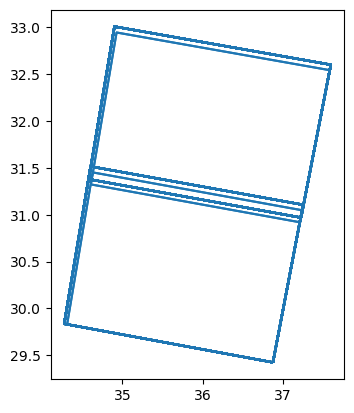

In [47]:
df_slcs[df_slcs.jpl_burst_id == 't021_043849_iw2'].exterior.plot()

Let's only get one of these.

In [48]:
df_slcs_filtered = df_slcs.groupby(['jpl_burst_id', 'date_acquired_str']).head(1)
df_slcs_filtered.shape

(66435, 28)

The plot is better now

<Axes: >

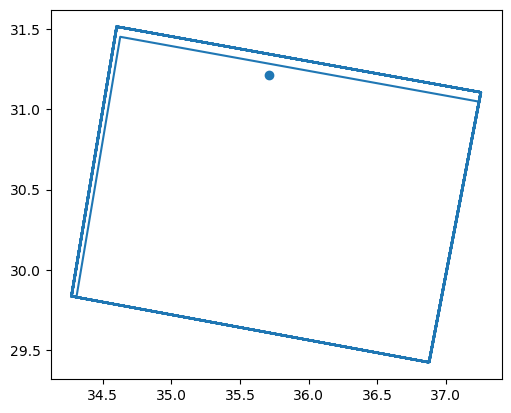

In [58]:
fig, ax = plt.subplots()
df_slcs_filtered[df_slcs_filtered.jpl_burst_id == 't021_043849_iw2'].exterior.plot(ax =ax)
df_sites[df_sites.site_id == 264].plot(ax=ax)

In [59]:
df_slcs_filtered.to_csv('slcs_for_processing.csv', index=False)